In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as f
import torch.utils.data as data_utils
from torch.utils.data.dataset import Dataset
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from torch.utils import data
import pandas as pd
from PIL import Image
import os
import torchvision
import numpy as np
from torch.autograd import variable

In [3]:
pip install torch===1.6.0 torchvision===0.7.0 -f https://download.pytorch.org/whl/torch_stable.html

Looking in links: https://download.pytorch.org/whl/torch_stable.html
     |████████████████████████████████| 748.8MB 15kB/s 
     |████████████████████████████████| 5.9MB 54.4MB/s 
  Found existing installation: torch 1.6.0+cu101
    Uninstalling torch-1.6.0+cu101:
      Successfully uninstalled torch-1.6.0+cu101
  Found existing installation: torchvision 0.7.0+cu101
    Uninstalling torchvision-0.7.0+cu101:
      Successfully uninstalled torchvision-0.7.0+cu101


In [4]:
transform=transforms.Compose([transforms.RandomHorizontalFlip(), transforms.RandomRotation(5), transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
train_data = torchvision.datasets.FashionMNIST(root = "./data", train = True, download = True, transform = transforms.ToTensor())
test_data = torchvision.datasets.FashionMNIST(root = "./data", train = False, download = True, transform = transforms.ToTensor())

batch_size = 150

train_loader = data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = data.DataLoader(test_data, batch_size=batch_size, shuffle=True)

Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw


Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw
Processing...
Done!





/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:469: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [5]:
class FashionMNIST(Dataset):
    def __init__(self, path, transform=None):
        self.transform = transform
        df = pd.read_csv(path)
        self.labels = df.label.values
        self.images = df.iloc[:, 1:].values.astype("uint8").reshape(-1, 28, 28)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        y = self.labels[idx]
        X = Image.fromarray(self.images[idx])
        
        if self.transform:
            X = self.transform(X)

        return X, y

In [6]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv_block = nn.Sequential(nn.Conv2d(1, 128, 3, 1, 1),
                                   nn.ReLU(),
                                   nn.MaxPool2d(2, 2),
                                   nn.Conv2d(128, 256, 3, 1, 1),
                                   nn.ReLU(),
                                   nn.MaxPool2d(2, 2))

        self.clf = nn.Sequential(nn.Linear(7 * 7 * 256, 1024),
                                  nn.ReLU(),
                                  nn.Linear(1024, 10),
                                  nn.Softmax(dim=1))

    def forward(self, x):
        x = self.conv_block(x)
        x = x.view(-1, 7 * 7 * 256)
        return self.clf(x)

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

model = Net()

model.to(device)
print(model)

#define loss
criterion = nn.CrossEntropyLoss()

#define optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

cuda
Net(
  (conv_block): Sequential(
    (0): Conv2d(1, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (clf): Sequential(
    (0): Linear(in_features=12544, out_features=1024, bias=True)
    (1): ReLU()
    (2): Linear(in_features=1024, out_features=10, bias=True)
    (3): Softmax(dim=1)
  )
)


In [8]:
acc_hist_train = []
acc_hist_test = []
n_epochs = 15

for epoch in range(n_epochs):
    #set train mode
    model.train() 
    acc_train = []
    acc_test = []
        
    for X,y in train_loader:
        X = X.to(device)
        y = y.to(device)
        optimizer.zero_grad()
        out = model(X)
        
        pred = out.detach().cpu().numpy()
        label = y.detach().cpu().numpy()
        a = (pred.argmax(axis=1) == label)
        acc_train.extend(a)
        
        loss = criterion(out, y)
        loss.backward()
        optimizer.step()
        
      
    print("Training Accuracy for {}: {}%".format(epoch+1, sum(acc_train) / len(acc_train) * 100))
    acc_hist_train.append(sum(acc_train) / len(acc_train))
        
    model.eval()
    
    with torch.no_grad():
        for X, y in test_loader:
            X = X.to(device)
            y = y.to(device)
            out = model(X)
            
            pred = out.detach().cpu().numpy()
            label = y.detach().cpu().numpy()
            a = (pred.argmax(axis=1) == label)
            acc_test.extend(a)
            
            loss = criterion(out, y)
            
        print("Validation Accuracy for {}: {}%".format(epoch+1, sum(acc_test) / len(acc_test) * 100))
        acc_hist_test.append(sum(acc_test) / len(acc_test))

Training Accuracy for 1: 71.22333333333334%
Validation Accuracy for 1: 84.48%
Training Accuracy for 2: 85.94666666666667%
Validation Accuracy for 2: 86.44%
Training Accuracy for 3: 87.96333333333334%
Validation Accuracy for 3: 87.91%
Training Accuracy for 4: 89.5%
Validation Accuracy for 4: 88.64%
Training Accuracy for 5: 90.46499999999999%
Validation Accuracy for 5: 89.33%
Training Accuracy for 6: 90.955%
Validation Accuracy for 6: 89.68%
Training Accuracy for 7: 91.29833333333333%
Validation Accuracy for 7: 89.75999999999999%
Training Accuracy for 8: 92.11500000000001%
Validation Accuracy for 8: 90.33%
Training Accuracy for 9: 92.28666666666666%
Validation Accuracy for 9: 89.96%
Training Accuracy for 10: 92.79333333333334%
Validation Accuracy for 10: 90.79%
Training Accuracy for 11: 93.15833333333333%
Validation Accuracy for 11: 90.16%
Training Accuracy for 12: 93.51333333333334%
Validation Accuracy for 12: 90.89%
Training Accuracy for 13: 93.86833333333333%
Validation Accuracy for 1

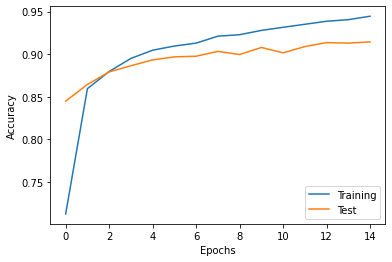

In [9]:
plt.plot(acc_hist_train, label="Training")
plt.plot(acc_hist_test, label="Test")
plt.legend(loc="lower right")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.show()